In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_saws(path, L, cache):
    """ Генерация случайных блужданий заданной дины без самопересечений """
    steps = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
    #
    if L == 0:
        cache.append(path)
    else:
        for dx, dy, dz in steps:
            x, y, z = path[-1]
            
            xyz_new = (x + dx, y + dy, z + dz)
            flag = True
            #
            for i in path:
                if xyz_new == i:
                    flag = False
                    break
            #
            if flag: 
                pp = path.copy()
                pp.append(xyz_new)
                generate_saws(pp, L - 1, cache)

                
def dist3D_2(point1, point2=(0, 0, 0)):
    """ Квадрат евклидова расстояния между двумя точками в 3D """
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    #     
    return (x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2


def minus3D(point1, point2):
    """ Вектор разницы между двумя веторами в 3D """
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    #     
    return (x2-x1, y2-y1, z2-z1)


def topological_n(path, point_number):
    """ Топологические соседи заданной точки блуждания """
    tops = []
    point = path[point_number]
    #     
    for cur_point in path:
        d = dist3D_2(point, cur_point)
        if d <= 1. and d >= 1e-3:
            tops.append(path.index(cur_point))
    #     
    return tops


def HP_seqs(k):
    """ Генерация всех HP-последовательностей заданной длины """
    seqs = []
    #     
    for i in range(2**(k+1)):
        cur_seq = [ int(x) for x in bin(i)[2:].zfill(k+1) ]
        if list(reversed(cur_seq)) not in seqs:
            seqs.append(cur_seq)
    # 
    return sorted(seqs, key=lambda arr: -sum(arr))


def Ising_seqs(k):
    seqs = []
    #     
    for i in range(2**(k+1)):
        cur_seq = [ int(x) for x in bin(i)[2:].zfill(k+1) ]
        if list(reversed(cur_seq)) not in seqs:
            seqs.append(cur_seq)
    #
    seqs = sorted(seqs, key=lambda arr: -sum(arr))
    #
    for seq in seqs:
        for i in range(k+1):
            if seq[i] == 0:
                seq[i] = -1
    return seqs


def HP_energy(path, seq):
    """ Количество топологических соседей HH заданной конформации """
    cnt = 0
    #     
    for point_number in range(len(path)):
        cur_tops = topological_n(path, point_number)
        #
        for i_neigh in cur_tops:
            cnt+=seq[point_number]*seq[i_neigh]
    #     
    return int(cnt/2.)


def Ising_energy(path, seq):
    """ Количество топологических соседей HH заданной конформации """
    cnt = 0
    #     
    for point_number in range(len(path)):
        cur_tops = topological_n(path, point_number)
        #
        for i_neigh in cur_tops:
            cnt += seq[point_number]*seq[i_neigh]
    #     
    return int(cnt/2.)


def Phi(seq):
    """ Доля H-элементов в последовательности """
    return sum(seq)/len(seq)


def R2_plot(max_n):
    """ График зависимости среднего квадрата расстояния между началом и концом блуждания от его длины """
    R2 = []
    # 
    for i in range(max_n):
        cache = []
        generate_saws([(0, 0, 0)], i+1, cache)
        r2_cur = 0
        # 
        for path in cache:
            r2_cur += dist3D_2(path[-1], path[0])
        # 
        r2_cur /= len(cache)
        R2.append(r2_cur)
    # 
    plt.plot([i+1 for i in range(max_n)], R2, 'ro')

    
def R2_plot_with_T(min_n, max_n, T_coef = 1., model = 'HP'):
    """ График зависимости среднего квадрата расстояния между началом и концом блуждания от его длины
        (температура < \inf) """
    R2 = []
    
    if model == 'HP':
        energy = HP_energy
        gen_seq = HP_seqs
    else:
        energy = Ising_energy
        gen_seq = Ising_seqs
    # 
    for i in range(min_n, max_n):
        cache = []
        generate_saws([(0, 0, 0)], i+1, cache)
        r2_cur = 0
        seqs = gen_seq(i+1)
        part_func = 0
        # 
        for path in cache:
            for seq in seqs:
                part_func += np.exp(-energy(path, seq)*T_coef)
                r2_cur += dist3D_2(path[-1], path[0])*np.exp(-energy(path, seq)*T_coef)
        #
        R2.append(r2_cur/part_func)
        print(R2[-1])
    #
    print(' that is all ')
    # 
#     plt.plot([i+1 for i in range(max_n)], R2, 'bo')
    return R2
    
    
def Rg2_plot(max_n):
    """ График зависимости среднего квадрата радиуса инерции блуждания от его длины """
    Rg2 = []
    # 
    for i in range(max_n):
        cache = []
        generate_saws([(0, 0, 0)], i+1, cache)
        rg2_cur = 0
        seqs = HP_seqs(i+1)
        # 
        for path in cache:
            for r_i in path:
                for r_j in path:
                    rg2_cur += dist3D_2(minus3D(r_i, r_j))
        #         
        rg2_cur /= 2.*len(cache)*(i+2)**2
        Rg2.append(rg2_cur)
    # 
#     plt.plot([i+1 for i in range(max_n)], Rg2, 'ro')
    return Rg2
    
    
def Rg2_plot_with_T(min_n, max_n, T_coef = 1., model = 'HP'):
    """ График зависимости среднего квадрата радиуса инерции блуждания от его длины 
        (температура < \inf) """
    Rg2 = []
    # 
    if model == 'HP':
        energy = HP_energy
        gen_seq = HP_seqs
    else:
        energy = Ising_energy
        gen_seq = Ising_seqs
        
    for i in range(min_n, max_n):
        cache = []
        generate_saws([(0, 0, 0)], i+1, cache)
        rg2_cur = 0
        seqs = gen_seq(i+1)
        part_func = 0
        # 
        for path in cache:
            for seq in seqs:
                part_func += np.exp(-energy(path, seq)*T_coef)
                for r_i in path:
                    for r_j in path:
                        rg2_cur += dist3D_2(minus3D(r_i, r_j))*np.exp(-energy(path, seq)*T_coef)
        #    
        Rg2.append(rg2_cur/(part_func * 2. * (i+2)**2))
        print(Rg2[-1])
    #
    print(' that is all ')
    # 
#     plt.plot([i+1 for i in range(max_n)], Rg2, 'ro')
    return Rg2

In [2]:
cache = []
generate_saws([(0,0,0)], 10, cache)
# len(HP_seqs(10))*len(cache)
# 9303231168

In [3]:
len(cache)

8809878

In [2]:
Rg2_plot(4)

[0.25, 0.4888888888888889, 0.73, 0.9897520661157024]

In [4]:
# как учитывать массы для радиуса инерции?

# какие ещё задания были?

In [ ]:
# R2_Ising = R2_plot_with_T(7, 10, T_coef = 0.5, model = 'Ising')
# R2_HP = R2_plot_with_T(10)
# Rg2_Ising = Rg2_plot_with_T(6, 8, model = 'Ising')
# Rg2_HP = Rg2_plot_with_T(10)

# T_coef = 1.
# R2_Ising = [1.0, 2.3999999999999977, 3.511723972983972, 4.773303742484766,
#             5.82303087859332, 6.709155638691144, 7.670119842160697]
# R2_HP = [1.0, 2.3999999999999995, 3.947195130432813, 5.6127156925494175, 
#          7.399642119535047, 9.255976733884564, 11.201481946650954]
# Rg2_Ising = [0.24999999999999992, 0.4888888888888894, 0.7005890672868395, 0.920813624235019, 
#              1.1285588957177852, 1.3029658107710114]
# Rg2_HP = [0.25000000000000006, 0.4888888888888888, 0.7353662777776907, 0.9949635729500705, 
#           1.269828267999719]

R2_HP = R2_plot_with_T(7, 10, T_coef = 0.5)
# T_coef = 0.5
# R2_Ising = [2.399999999999999, 3.8352126298583924, 5.348788211275434, 6.997772366170236,
#            8.52533345444821, 10.320452121029538, 11.870886743329194]
# R2_HP = [2.4000000000000004, 3.9254719886055836, 5.6051967210940115, 7.361471067564311, 
#          9.22544622605394, 11.139718119552922, ]
# Rg2_Ising = []
# Rg2_HP = []

In [ ]:
np.asarray(Rg2_plot_with_T(5, model = 'Ising'))-np.asarray(Rg2_plot_with_T(5))

In [ ]:
np.asarray(Rg2_plot_with_T(6))-np.asarray(Rg2_plot(6))

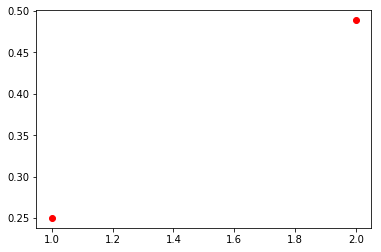

In [7]:
Rg2_plot(2)

In [2]:
cache = []
generate_saws([(0, 0, 0)], 4, cache)
# print(cache)
# HP_seqs(4)
# for path in cache:
#     topological_n(path, 1)

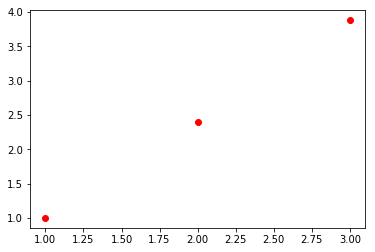

In [12]:
R2_plot(3)

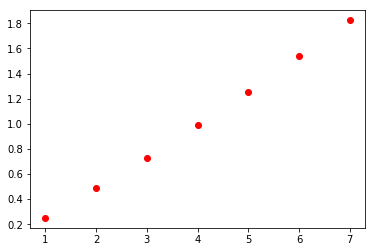

In [4]:
Rg2_plot(7)

In [ ]:
R2g = []

hp_seqs = HP_seqs(5)

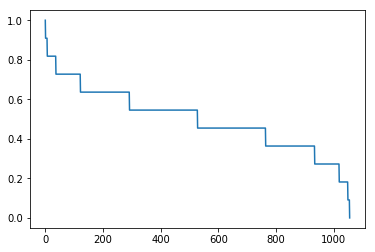

In [39]:
plt.plot([i for i in range(len(HP_seqs(10)))], [Phi(seq) for seq in HP_seqs(10)])

In [ ]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import random as rand

cache = []
generate_saws([(0,0,0)], 10, cache)

rand.seed(42)

rand_walk = cache[rand.randint(0, len(cache))]
x = []
y = []
z = []
for x_dot, y_dot, z_dot in rand_walk:
    x.append(x_dot)
    y.append(y_dot)
    z.append(z_dot)
fig = plt.figure(figsize=(10.,10.))
ax = fig.gca(projection='3d')
ax.plot(np.asarray(x), np.asarray(y), np.asarray(z))

ax.scatter(np.asarray(x[0:-1]), np.asarray(y[0:-1]), np.asarray(z[0:-1]), color="b", s=20)
ax.scatter(np.asarray(x[-1]), np.asarray(y[-1]), np.asarray(z[-1]), color="r", s=30)

u, v = np.mgrid[0.5*np.pi:np.pi:20j, 0.:0.5*np.pi:20j]
R = dist3D_2(rand_walk[-1], rand_walk[0])**0.5
x_R = R*np.cos(u)*np.sin(v)
y_R = R*np.sin(u)*np.sin(v)
z_R = R*np.cos(v)
ax.plot_surface(x_R, y_R, z_R, alpha=0.3, color="r")

Rg2 = 0
for r_i in rand_walk:
    for r_j in rand_walk:
        Rg2 += dist3D_2(minus3D(r_i, r_j))
Rg2 /= 2.*11.*11.
Rg = Rg2**0.5
x_R = Rg*np.cos(u)*np.sin(v)
y_R = Rg*np.sin(u)*np.sin(v)
z_R = Rg*np.cos(v)
ax.plot_surface(x_R, y_R, z_R, alpha=0.3, color="r")
# ax.plot_wireframe(x_R, y_R, z_R, color="r")

ax.view_init(30, 120)
plt.savefig("plot.png")
plt.show()